# Interconnect Churn Prediction

## Overview
The goal is to build a machine learning model that predicts **customer churn** for Interconnect, a telecom operator. Accurate churn predictions help the business proactively retain at-risk customers with targeted offers.

## Data Sources
All files are linked by `customerID`:
- `contract.csv` — contract details and billing
- `personal.csv` — demographic attributes
- `internet.csv` — internet service flags and add-ons
- `phone.csv` — phone service flags

## Target & Metrics
- **Target:** `EndDate` → `0` if `"No"` (active), `1` if it’s a date (churned)
- **Primary metric:** AUC-ROC  
- **Additional metrics:** Accuracy (plus Precision/Recall/F1 due to class imbalance)

## Notebook Roadmap
1. **Step 1 — Contract cleanup & core features:** build `churn` target, fix numeric fields, engineer `tenure_months`, and validate the frame.
2. **Step 2 — Merge auxiliary tables:** join `personal`, `internet`, and `phone`; fill missing service flags.
3. **Step 3 — Encoding & modeling:** prepare features, train/evaluate baseline and boosting models, report metrics.


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

### Step 1: Clean 'contract' & create target/tenure

In [3]:
# 1) Confirm columns & strip whitespace just in case 
for df in [contract, personal, internet, phone]:
    df.columns= df.columns.str.strip()

In [4]:
# 2) Target: churn = 1 if EndDate is a date, 0 if "No"
    # Terget: 0 = active , 1 = churned
contract['churn'] = (contract['EndDate'] != 'No').astype(int)

In [5]:
# 3) Handle TotalCharges blanks (dropping rows as they are very few - 11 rows)
blank_tc = contract['TotalCharges'].astype(str).str.strip().eq('')
print(f"Blank TotalCharges rows found: {blank_tc.sum()}")
contract = contract.loc[~blank_tc].copy()  # creates a copy of the filtered DataFrame.

Blank TotalCharges rows found: 11


In [6]:
# 4) Convert Types
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'], errors = 'coerce')

# If any coercion produced NaN, drop them
num_na = contract[['MonthlyCharges','TotalCharges']].isna().sum()
print("Numeric NA after conversion:\n", num_na.to_string())

contract = contract.dropna(subset=['MonthlyCharges','TotalCharges']).copy()

Numeric NA after conversion:
 MonthlyCharges    0
TotalCharges      0


In [7]:
# 5) Date & Tenure Calculation
snapshot_date = pd.to_datetime('2020-02-01') # Give by task
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

# Convert EndDate where possible; keep NaT for "No"
end_dt = pd.to_datetime(contract['EndDate'].replace('No', np.nan), errors='coerce')
contract ['end_effective'] = end_dt.fillna(snapshot_date)

# Tenure in months; clip negatives to 0 just in case
contract['tenure_months'] = (contract['end_effective'] - contract['BeginDate']).dt.days // 30 
contract['tenure_months'] = contract['tenure_months'].clip(lower=0) 

In [8]:
# 6) Keep only the columns we need from contract
keep_cols = [
    'customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges', 'tenure_months', 'churn'
]
contract_clean = contract[keep_cols].copy()

In [9]:
# 7) Quick sanity check

print("\n===== Sanity Check =====")
print("Rows after cleaning:", len(contract_clean))
print("Churn distribution:\n", contract_clean['churn'].value_counts(normalize=True).round(4))
print("\nNumberic summary:\n", contract_clean[['MonthlyCharges', 'TotalCharges', 'tenure_months']].describe())
display(contract_clean.head(10))


===== Sanity Check =====
Rows after cleaning: 7032
Churn distribution:
 churn
0    0.7342
1    0.2658
Name: proportion, dtype: float64

Numberic summary:
        MonthlyCharges  TotalCharges  tenure_months
count     7032.000000   7032.000000    7032.000000
mean        64.798208   2283.300441      32.566411
std         30.085974   2266.771362      24.768107
min         18.250000     18.800000       1.000000
25%         35.587500    401.450000       9.000000
50%         70.350000   1397.475000      29.000000
75%         89.862500   3794.737500      55.000000
max        118.750000   8684.800000      73.000000


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_months,churn
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,34,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,2,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,45,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,2,1
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,8,1
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,22,0
7,6713-OKOMC,Month-to-month,No,Mailed check,29.75,301.90,10,0
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,28,1
9,6388-TABGU,One year,No,Bank transfer (automatic),56.15,3487.95,62,0


### Step 1 — What We Did (Clean `contract` and build target + tenure)

1) **Standardize column names**  
   - *What:* Strip whitespace from column headers.  
   - *Why:* Prevents silent bugs when referencing columns by name.

2) **Create the binary target `churn`**  
   - *What:* `churn = 1` if `EndDate` is a date; `churn = 0` if `EndDate == "No"`.  
   - *Why:* Converts the business definition of churn into a learnable label for classification.

3) **Handle `TotalCharges` blanks**  
   - *What:* Detect 11 rows where `TotalCharges` is an empty string and **drop** them.  
   - *Why:* Ensures clean numeric conversion and avoids introducing noise for a tiny fraction of rows.

4) **Convert money columns to numeric**  
   - *What:* `MonthlyCharges` and `TotalCharges` → `pd.to_numeric(..., errors="coerce")`, then drop any rare NaNs.  
   - *Why:* These are monetary features; models need them as floats (not strings or datetimes).

5) **Convert dates and compute effective end date**  
   - *What:* Parse `BeginDate` as datetime. For `EndDate`, use a **snapshot date of 2020-02-01** when `EndDate == "No"`; otherwise use the actual churn date.  
   - *Why:* We need a consistent “end point” to measure how long each customer has been with Interconnect.

6) **Engineer `tenure_months`**  
   - *What:* `tenure_months = floor((end_effective − BeginDate) in days / 30)`, clipped at 0.  
   - *Why:* Tenure is a strong churn predictor and converts dates into a single informative numeric feature.

7) **Keep the essentials for downstream steps**  
   - *What:* Retain: `customerID`, `Type`, `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`, `tenure_months`, `churn`.  
   - *Why:* Keeps the working frame tidy and ready for merges.

8) **Sanity checks**  
   - *What:* Print row count, class balance of `churn`, and descriptive stats for numeric fields.  
   - *Why:* Verifies that cleaning worked (no accidental data loss, reasonable ranges, and expected class imbalance).

> Outcome: A clean `contract_clean` dataframe with a correct `churn` label and the key engineered feature `tenure_months`, ready to be merged with `personal`, `internet`, and `phone` in Step 2.


---

### Step 2: Merge All Tables , Exploratory Data Analysis

In [10]:
# 1) Merge contrat + personal + internet + phone
df = (contract_clean
.merge(personal, on='customerID', how='left')
.merge(internet, on='customerID', how='left')
.merge(phone, on='customerID', how='left')
)

print("Merged shape:", df.shape)

Merged shape: (7032, 20)


In [11]:
# 2) Fill missing service info:
#    If a customer doesn not appear in internet.csv or phone.csv, they do not have that service.
#    and their service should be "No"
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for c in internet_cols:
    if c in df.columns: 
        df[c] = df[c].fillna('No')

if 'MultipleLines' in df.columns:
    df['MultipleLines'] = df['MultipleLines'].fillna('No')

In [17]:
# 3) Quick sanity check
print("\n===== sample after merge =====")
display(df.head(5))
print("\nMissing values summary:\n", df.isna().sum())


===== sample after merge =====


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_months,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,34,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,2,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,45,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,2,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Missing values summary:
 customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
tenure_months       0
churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


### EDA and Visualization

Overall Churn Rate: 26.58%


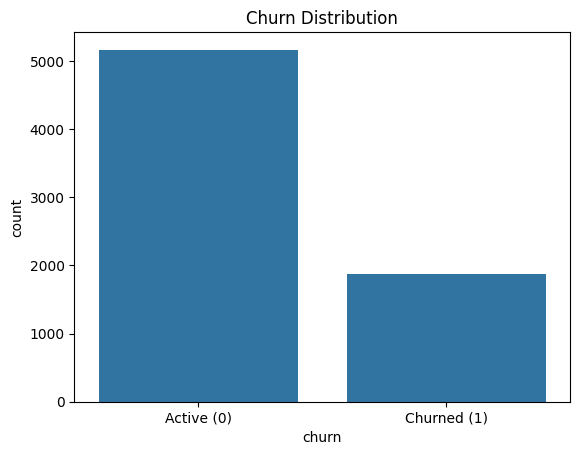

In [19]:
# 1) Overal Churn distribution
churn_rate = df['churn'].mean()
print(f"Overall Churn Rate: {churn_rate:.2%}")

sns.countplot(data=df, x='churn')
plt.title('Churn Distribution')
plt.xticks([0,1], ['Active (0)', 'Churned (1)'])
plt.show()

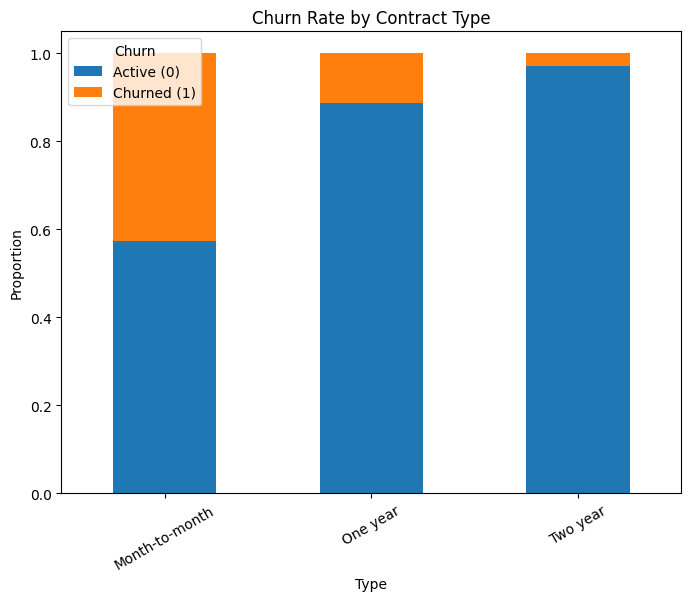

In [28]:
# 2) Churn by contract type

ct = pd.crosstab(df['Type'], df['churn'], normalize='index').round(4)
ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion')
plt.xticks(rotation=30)
plt.legend(title='Churn', labels=['Active (0)', 'Churned (1)'])
plt.show()

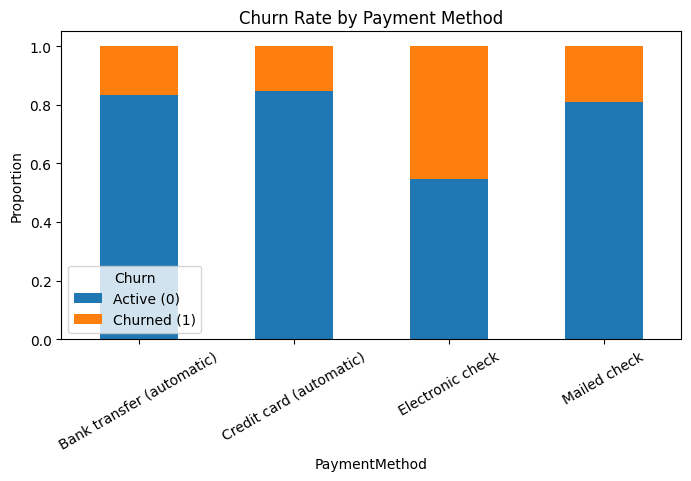

In [27]:
# 3) Churn by payment method

pm= pd.crosstab(df['PaymentMethod'], df['churn'], normalize='index').round(4)
pm.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title('Churn Rate by Payment Method')
plt.ylabel('Proportion')
plt.xticks(rotation=30)
plt.legend(title='Churn', labels=['Active (0)', 'Churned (1)'])
plt.show()

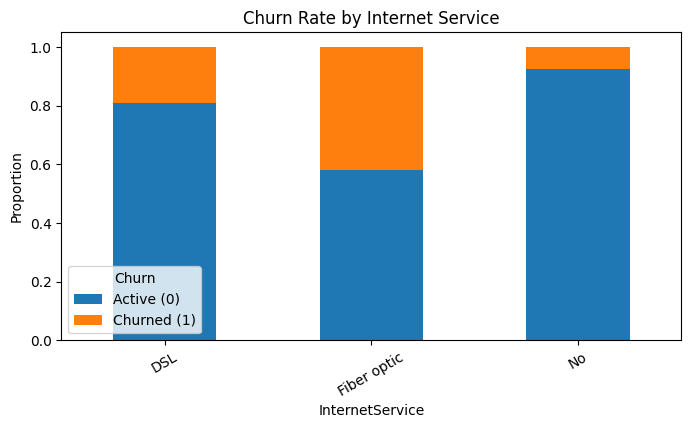

In [30]:
# 4) Churn by Internet Service
isvc = pd.crosstab(df['InternetService'], df['churn'], normalize='index').round(4)
isvc.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title('Churn Rate by Internet Service')
plt.ylabel('Proportion')
plt.xticks(rotation=30)
plt.legend(title='Churn', labels=['Active (0)', 'Churned (1)'])
plt.show()

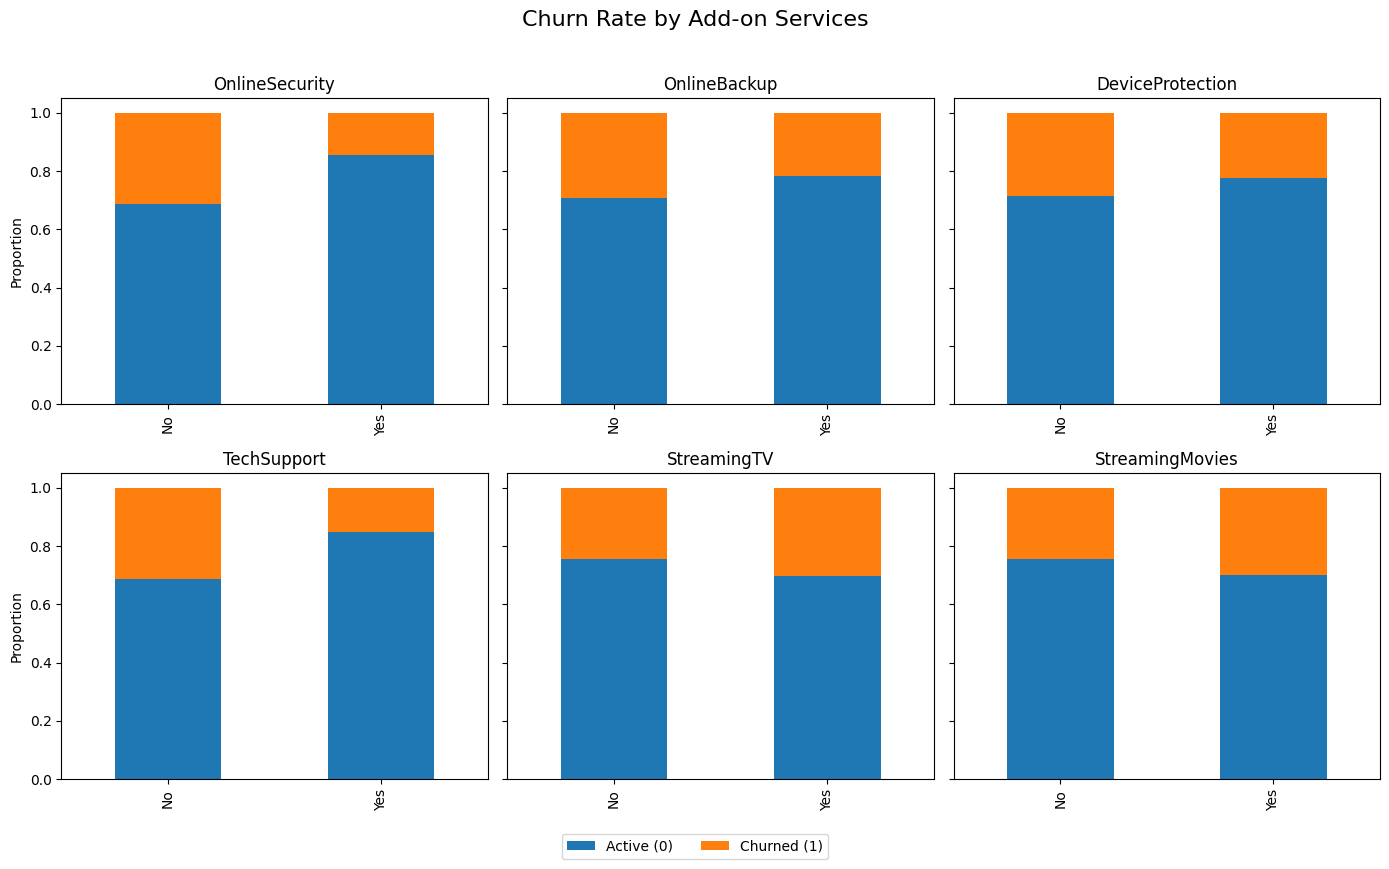

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
axes = axes.flatten()

for i, col in enumerate(addons):
    if col in df.columns:
        addon_ct = pd.crosstab(df[col], df['churn'], normalize='index')
        addon_ct.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
        axes[i].set_title(f"{col}")
        axes[i].set_ylabel("Proportion")
        axes[i].set_xlabel("")
        axes[i].set_xticklabels(['No','Yes'])

# legend with margin
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Active (0)','Churned (1)'],
           loc='lower center', ncol=2,
           bbox_to_anchor=(0.5, -0.05))  # pushes legend slightly below

# adjust bottom margin so legend isn’t cut off
plt.subplots_adjust(bottom=0.15)

fig.suptitle("Churn Rate by Add-on Services", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


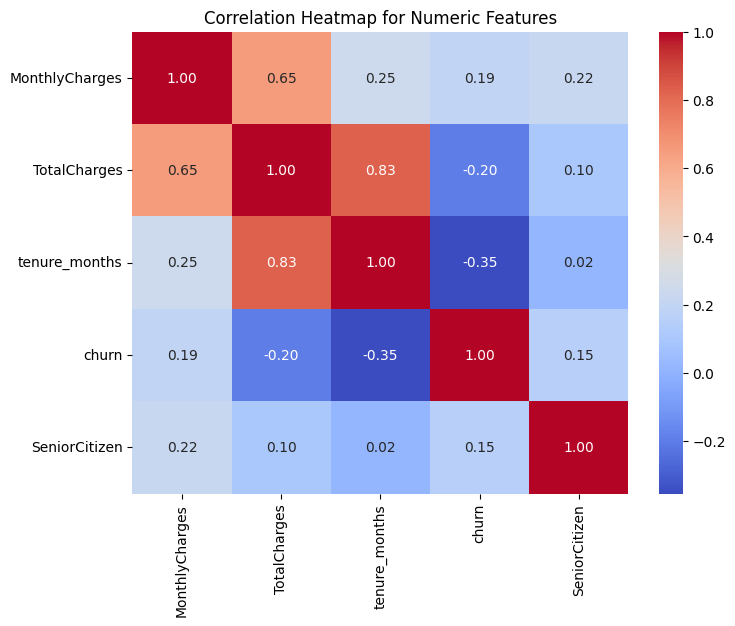

In [36]:
# 6) Correlation heatmap for numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Features')
plt.show()

## Step 2 — Merge & Exploratory Data Analysis (EDA)

### 2.1 Merging the Tables
I merged all four datasets (`contract`, `personal`, `internet`, `phone`) on the `customerID` key:
- Used **left joins** starting from the cleaned `contract` table.  
- Filled missing service data with `"No"`:
  - If a customer had no row in `internet.csv` → `InternetService = "No"` and all internet add-ons = `"No"`.  
  - If a customer had no row in `phone.csv` → `MultipleLines = "No"`.  
- This produced a single unified dataframe (`df`) with all customer information consolidated.

---

### 2.2 Exploratory Data Analysis

**Overall churn rate**  
- ~26–27% churn.  
- Dataset is imbalanced, with ~73% active customers.

**Contract type**  
- *Month-to-month* → highest churn.  
- *1-year* and *2-year* → much lower churn, especially 2-year.  
- ➡️ Long-term contracts are a strong retention driver.

**Payment method**  
- *Electronic check* customers churn significantly more.  
- Automatic payments (*credit card* / *bank transfer*) show lower churn.  
- ➡️ Payment method choice is a meaningful churn signal.

**Internet service type**  
- *Fiber optic* users churn more than *DSL*.  
- Customers with *no internet* have very low churn.  
- ➡️ Fiber optic customers may be less satisfied or more price-sensitive.

**Add-on services**  
- *OnlineSecurity* and *TechSupport* are associated with much lower churn.  
- *OnlineBackup* and *DeviceProtection* show smaller effects.  
- *Streaming services* don’t reduce churn meaningfully.  
- ➡️ Support/security services help keep customers loyal.

**Numeric correlations**  
- `tenure_months` strongly **negatively** correlated with churn.  
- `MonthlyCharges` weakly positively correlated with churn.  
- `SeniorCitizen` slightly positively correlated with churn.  
- ➡️ Tenure is the strongest numeric predictor of retention.

---

### 2.3 Summary
- After merging, we now have a complete dataset (`df`) with all customer, contract, internet, and phone features.  
- EDA confirms **contract type, payment method, internet service type, tenure, and support/security add-ons** are the most influential factors in churn.  
- The dataset is imbalanced, which we’ll address during modeling with techniques like class weights or resampling.  
<br/><br/>
> **Outcome:** Data is clean, merged, and analyzed. Key churn drivers have been identified, and the dataset is ready for feature engineering and model preparation.
